In [318]:
from google.colab import drive
drive.mount('/content/drive') # remove the cell if colab is not used

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [319]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
base_path = Path('/content/drive/MyDrive/data') # Pass path to data folder here, e.g. Path('/content/drive/MyDrive/data') if using Google Drive

# **1. Analiza i przetwarzanie danych na temat Titanica**

#### Wyobraź sobie, że pewnego wakacyjnego dnia, będąc na plaży w pełnym słońcu, odbierasz telefon od nieznanego numeru.
Robisz to niechętnie — zasłużyłeś/aś przecież na odpoczynek i chcesz mieć ten czas tylko dla siebie. Już masz na końcu języka wymijającą odpowiedź, gdy nagle z drugiej strony słyszysz:
„Czy jesteś gotowy, by tego lata rozwikłać jedną z największych zagadek ludzkości?”

Jako osoba z natury ciekawa świata i ze świetnym umysłem analitycznym, szybko zapominasz o plaży i wakacjach. Zaintrygowany/a dopytujesz o szczegóły, ale rozmówca nie chce zdradzić zbyt wiele. Wiadomo jedynie, że chodzi o *zatonięcie Titanica w 1914* roku, a celem misji jest ustalenie, które osoby miały szansę przeżyć.

**Ty** — jako **renomowany analityk danych** — byłeś/byłaś ich pierwszym wyborem do analizy i oczyszczenia danych. Mimo wątpliwości postanawiasz podjąć się zadania, mając nadzieję, że twoja wiedza może zostać praktycznie wykorzystana w słusznym celu.

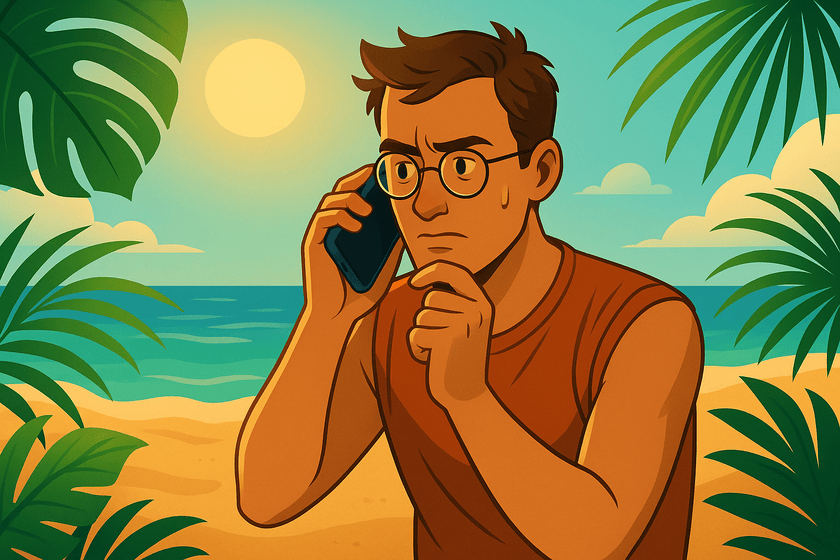

(*AI-generated image*)


#### Twoim celem będzie przeanalizowanie i przetworzenie zbioru danych w taki sposób, by mógł on być użyty do nauki modelu do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

(Uwaga: w tym zadaniu nie będziesz trenować modeli, ta przyjemność spotka cię w następnych notebookach)

Poniżej znajdziesz pytania, które mogą być pomocne w analizie, oraz odwołania do poszczególnych sekcji z notebooka do lekcji:

- Czy wszystkie kolumny są istotne w kontekście zadania?
- Czy występują brakujące wartości? Jeśli tak, to jak je uzupełnisz? (sekcja #2.1)
- Czy typy danych są odpowiednie do znaczenia kolumny? (sekcja #1.3)
- Czy dystrybucje danych mają rozkłady normalne, czy asymetryczne? (sekcja #4.1 + wykład)
- Która zmienna oznacza predykowaną klasę?
- Jaki jest rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych? (sekcja #4.1)
- Czy końcowe rozkłady zawierają wartości skrajne? (sekcja #4.2 + wykład)

Wymagania:

- Zbiór musi być oczyszczony, tj. finalnie nie powinien mieć brakujących wartości (sekcja #2.1)
- Zbiór musi zawierać co najmniej dwie dodatkowe kolumny, które mogą wzbogacić informacje zawarte w zbiorze (sekcje #1.5 i #2.2)
- Cechy kategorialne powinny być zakodowane, postaraj się dobrać odpowiedni sposób (sekcja #2.3)
- Zbadaj, czy występują skrajne wartości (outliery) zarówno dla wartości numerycznych, jak i dla kategorialnych
- Każda cecha powinna być zwizualizowana co najmniej raz. Sam(a) zastanów się, czy warto wizualizować cechy parami w celu odkrycia zależności między nimi (sekcja #4.4)
- Nie ma ograniczenia na liczbę komórek, ale zastanów się, czy dana wizualizacja/obliczenie jest przydatne w całej analizie, czy po prostu sobie "egzystuje" bez żadnych wniosków

Zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Poniżej zamieszczamy tabelę z wyjaśnieniem poszczególnych kolumn:

| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Czy pasażer przeżył (0 = nie, 1 = tak).                                         |
| **Pclass**   | Klasa podróży (1 = I klasa, 2 = II klasa, 3 = III klasa).                       |
| **Name**     | Imię i nazwisko pasażera.                                                       |
| **Sex**      | Płeć pasażera (male = mężczyzna, female = kobieta).                             |
| **Age**      | Wiek pasażera w latach.                                                         |
| **SibSp**    | Liczba rodzeństwa i małżonków na pokładzie.                                     |
| **Parch**    | Liczba rodziców i dzieci na pokładzie.                                          |
| **Ticket**   | Numer biletu.                                                                   |
| **Fare**     | Cena biletu.                                                                    |
| **Cabin**    | Numer kabiny pasażera                                     |
| **Embarked** | Port, w którym pasażer wsiadł (C = Cherbourg, Q = Queenstown, S = Southampton). |
                                                         |


In [320]:
titanic_df = pd.read_csv(base_path / 'titanic.csv', index_col='PassengerId')

###**1.1. EDA**

---

**Rozpoczynamy od sprawdzenia jak wygląda struktura danych**

---

In [321]:
titanic_df.iloc[814:844]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
815,0,3,"Tomlin, Mr. Ernest Portage",male,30.50,0,0,364499,8.0500,NaN,S
816,0,1,"Fry, Mr. Richard",male,NaN,0,0,112058,0.0000,B102,S
817,0,3,"Heininen, Miss. Wendla Maria",female,23.00,0,0,STON/O2. 3101290,7.9250,NaN,S
818,0,2,"Mallet, Mr. Albert",male,31.00,1,1,S.C./PARIS 2079,37.0042,NaN,C
819,0,3,"Holm, Mr. John Fredrik Alexander",male,43.00,0,0,C 7075,6.4500,NaN,S
820,0,3,"Skoog, Master. Karl Thorsten",male,10.00,3,2,347088,27.9000,NaN,S
821,1,1,"Hays, Mrs. Charles Melville (Clara Jennings Gr...",female,52.00,1,1,12749,93.5000,B69,S
822,1,3,"Lulic, Mr. Nikola",male,27.00,0,0,315098,8.6625,NaN,S
823,0,1,"Reuchlin, Jonkheer. John George",male,38.00,0,0,19972,NaN,NaN,S


In [322]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Name      891 non-null    object 
 3   Sex       891 non-null    object 
 4   Age       714 non-null    float64
 5   SibSp     891 non-null    int64  
 6   Parch     891 non-null    int64  
 7   Ticket    891 non-null    object 
 8   Fare      793 non-null    float64
 9   Cabin     204 non-null    object 
 10  Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 83.5+ KB


**Sprawdzamy które dane są ważne a które mniej w kotekście zadania**


---



| Kolumna      | Opis                                                                            |
| ------------ | ------------------------------------------------------------------------------- |
| **Survived** | Ważne przyda się do określenia czy osoba przeżyła czy też nie.                                         |
| **Pclass**   | Zostawiamy przyda się przy określeniu jaka klasa podróży miała większe szanse na przeżycie.                       |
| **Name**     | Totalnie nie potrzebne (powoduje szum) .                                                       |
| **Sex**      | Zostawiamy (Płeć osoby która przeżyła).                             |
| **Age**      | Zostawiamy (Wiek pasażera w latach).                                                         |
| **SibSp**    | Zostawiamy (Liczba rodzeństwa i małżonków na pokładzie).                                     |
| **Parch**    | Zostawiamy (Liczba rodziców i dzieci na pokładzie).                                          |
| **Ticket**   | Wyrzucamy ponieważ próba staje się nie reprezentatywna bo każdy ma swój indywidualny numer biletu.                                                                   |
| **Fare**     | Zostawiamy Cena biletu może świadczyć o statusie majętności.                                                                    |
| **Cabin**    | Wyrzucamy (każda kajuta ma swój indywidualny nie jest reprezentatywna powodować będzie tylko szum ).                                   |
| **Embarked** | Zostawiamy |
                                                         |



**Wyciągamy tytuły z kolumny** `Name` **by uzupełnić brakujące wartości w kolumnie age za pomocą mediany**




---



In [323]:
titanic_df['Title'] = titanic_df['Name'].str.extract(r' ([A-Za-z]+)\.')
titanic_df['Age'] = titanic_df['Age'].fillna(
    titanic_df.groupby('Title')['Age'].transform('median')
)

**Zaokrąglamy wartości nie będące liczbami całkowitymi i zmieniamy datatype wieku z** `float64` **na** `int64`

---



In [324]:
titanic_df['Age'] = np.round(titanic_df['Age'])

In [325]:
titanic_df['Age'] = pd.to_numeric(titanic_df['Age']).astype('int64')

**Dodajemy nową kolumnę z wielkością rodziny.**

---



In [326]:
titanic_df['FamilySize'] = titanic_df['SibSp'] + titanic_df['Parch'] + 1

**Dodajemy kolejną nową kolumnę z literą pokładu wyciągniętą z kolumny.** `cabin`

---



In [327]:
titanic_df['Deck'] = titanic_df['Cabin'].str[0]

In [328]:
titanic_df['Deck'].value_counts()

,count
Deck,
C,59
B,47
D,33
E,32
A,15
F,13
G,4
T,1


**Uzupełniamy brakujące dane w kolumine na podstawie rozkładu w danej klasie pasażerskiej na podstawie rozkładu danych nie brakujących**


---



In [329]:
def sample_deck(row):
    deck_dist = titanic_df.dropna(subset=['Deck']).groupby('Pclass')['Deck'].value_counts(normalize=True)
    if pd.isna(row['Deck']):
        pclass = row['Pclass']
        dist = deck_dist[pclass]
        return np.random.choice(dist.index, p=dist.values)
    else:
        return row['Deck']
titanic_df['Deck'] = titanic_df.apply(sample_deck, axis=1)

**Uzupełniam braki w kolumnie "Embarked" za pomocą najczęściej występującej wartości**

---



In [330]:
most_common = titanic_df['Embarked'].mode()[0]
titanic_df['Embarked'] = titanic_df['Embarked'].replace('Unknown', most_common)

**Wypełniamy puste wartości medianą i zrzucamy niepotrzebne kolumny**

---



In [331]:
titanic_df['Fare'] =titanic_df['Fare'].fillna(titanic_df.groupby(['Pclass', 'Embarked'])['Fare'].transform('median'))

In [332]:
titanic_df['Fare'] = np.ceil(titanic_df['Fare']*100)/100

In [333]:
titanic_df=titanic_df.drop(columns=['Name','Ticket','Cabin','Title'])
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    int64  
 1   Pclass      891 non-null    int64  
 2   Sex         891 non-null    object 
 3   Age         891 non-null    int64  
 4   SibSp       891 non-null    int64  
 5   Parch       891 non-null    int64  
 6   Fare        891 non-null    float64
 7   Embarked    889 non-null    object 
 8   FamilySize  891 non-null    int64  
 9   Deck        891 non-null    object 
dtypes: float64(1), int64(6), object(3)
memory usage: 76.6+ KB


**Wszystkie wartości zostały uzupełnione przechodzimy do wizualizacji**

---



### **1.2. Wizualizacja Danych**

  **Patrzymy na dystrybucje danych, stosujemy histogramy dla wartości numerycznych**

---



In [334]:
def plot_numeric_histogram(df, column_name):
    """
    Plots a histogram for the specified column in the DataFrame,
    and adds vertical lines for the mean and median.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the column to plot.
    Returns:
        None. Displays the histogram.
    """

    data = df[column_name].dropna()
    mean_val = data.mean()
    median_val = data.median()

    plt.figure(figsize=(6, 4))
    plt.hist(data, bins=30, color='steelblue', edgecolor='black')
    plt.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.2f}')
    plt.axvline(median_val, color='green', linestyle='-', linewidth=2, label=f'Median: {median_val:.2f}')

    plt.title(f'Distribution of {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Frequency')
    plt.legend()
    plt.tight_layout()
    plt.show()


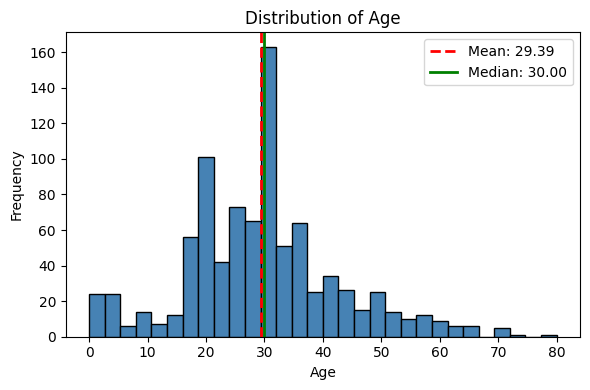

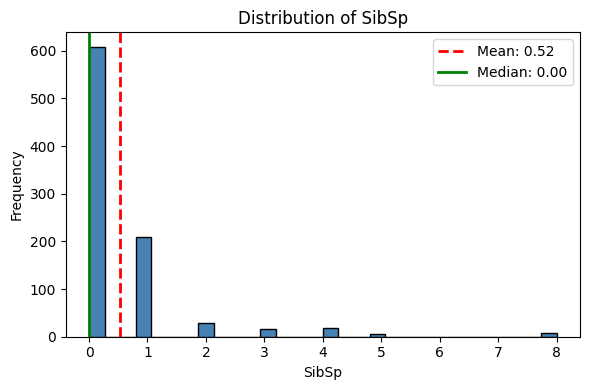

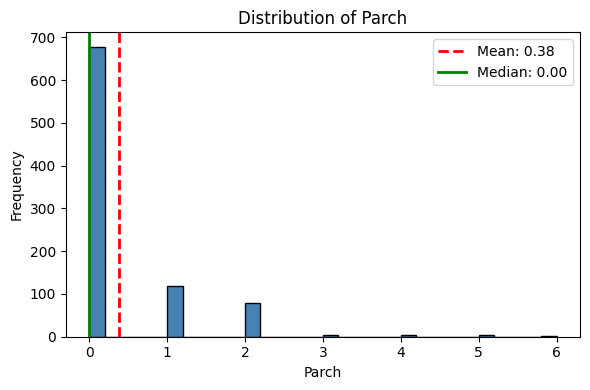

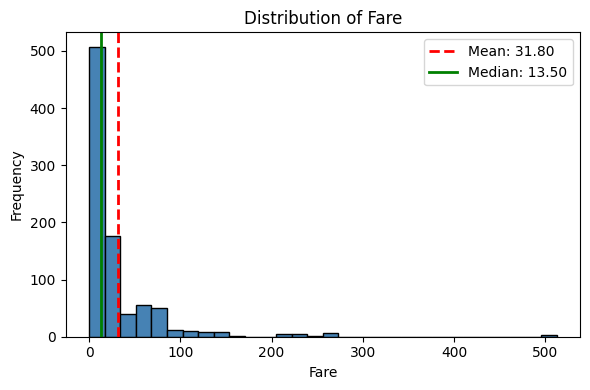

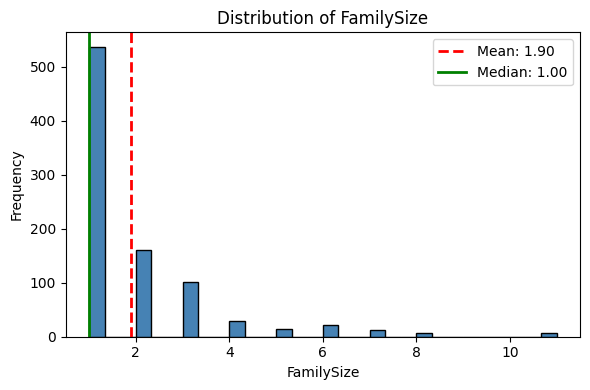

In [335]:
for col in ['Age','SibSp','Parch','Fare','FamilySize']:
  plot_numeric_histogram(titanic_df,col)

**Spoglądamy na wartości skrajne w kolumnach z wartościami numerycznymi, stosujemy do tego wykresy pudełkowe**


---



In [336]:
def boxplot(df, column_name):
    """
    Displays a boxplot of the choosen column to show its distribution.
    Parameters:
        df (pandas.DataFrame): The DataFrame containing the data.
        column_name (str): The name of the categorical column to plot.
    Returns:
        None. Displays the bar chart.
    """
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=df[column_name].dropna(), color='lightgreen') # as you can see, you can use sns and plt at the same time
    plt.title(f'Distribution of {column_name} (boxplot)')
    plt.xlabel(column_name)

    plt.show()

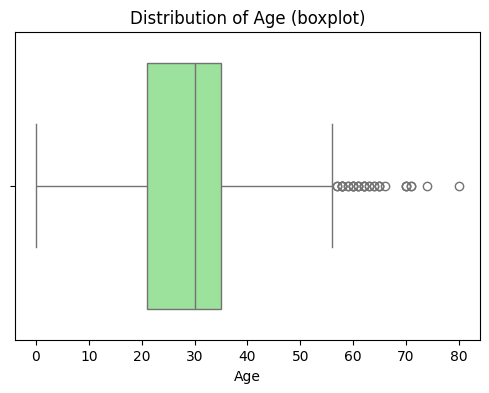

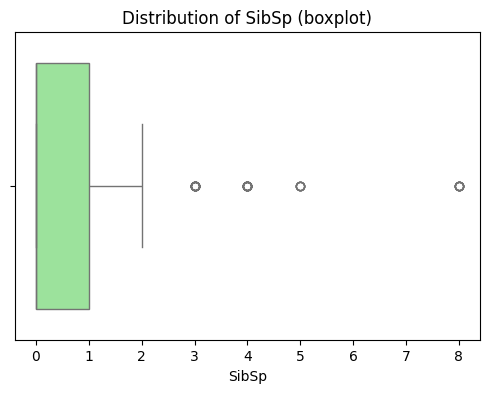

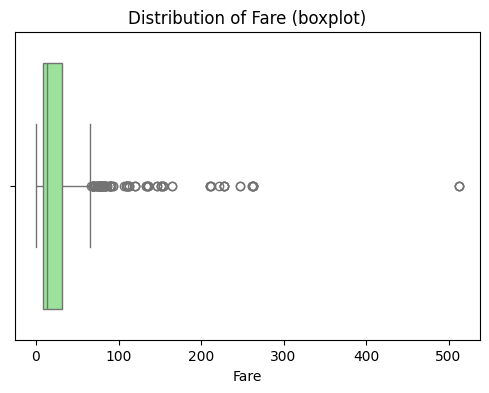

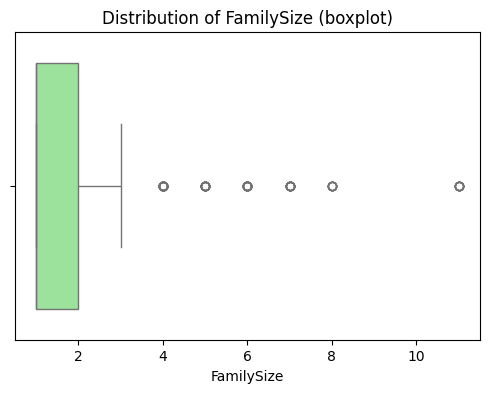

In [337]:
for col in ['Age','SibSp','Fare','FamilySize']:
  boxplot(titanic_df,col)


In [338]:
Q1 = titanic_df['Fare'].quantile(0.25) # lower quantile
Q3 = titanic_df['Fare'].quantile(0.75) # upper quantile
IQR = Q3 - Q1
upper_bound = Q3 + 3 * IQR

**Sprawdzamy rozkład zmiennej predykowanej względem zmiennych kategorialnych, jak i numerycznych**


---



In [339]:
def plot_survival_by_category(df, column_name):
    """
    Plots survival counts and rates for a categorical column.
    Parameters:
        df (pandas.DataFrame): DataFrame z danymi.
        column_name (str): Nazwa kolumny kategorialnej.
    """
    plt.figure(figsize=(7, 5))
    sns.countplot(data=df, x=column_name, hue='Survived', palette='Set2', edgecolor='black')
    plt.title(f'Survival counts by {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Count')
    plt.legend(title='Survived', labels=['No', 'Yes'])
    plt.tight_layout()
    plt.show()

    rates = df.groupby(column_name)['Survived'].mean().reset_index()
    rates['SurvivalRate %'] = rates['Survived'] * 100

    plt.figure(figsize=(7, 4))
    sns.barplot(data=rates, x=column_name, y='SurvivalRate %', color='steelblue', edgecolor='black')
    plt.title(f'Survival rate (%) by {column_name}')
    plt.xlabel(column_name)
    plt.ylabel('Survival Rate (%)')
    plt.ylim(0, 100)
    plt.tight_layout()
    plt.show()

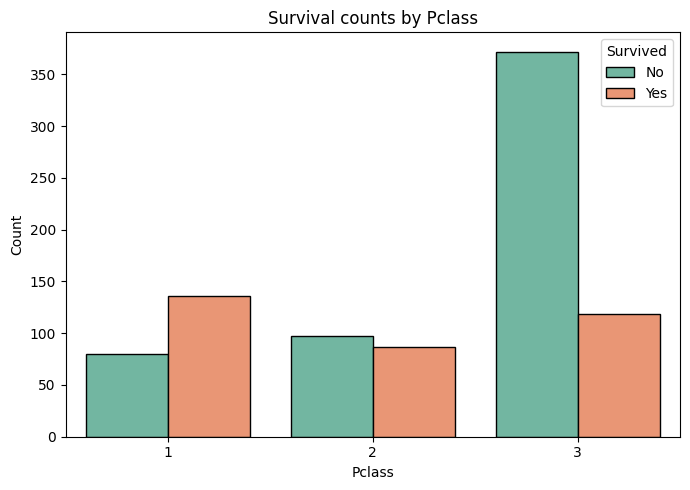

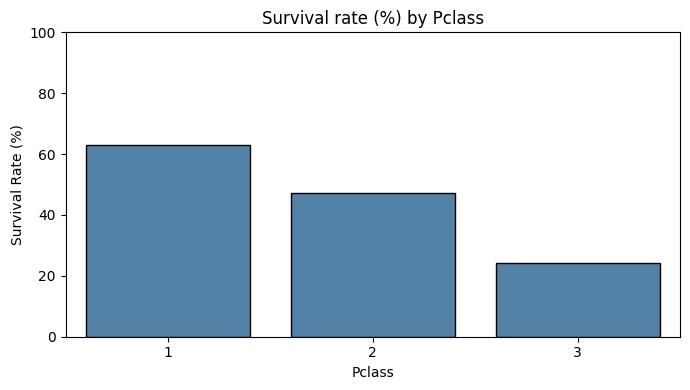

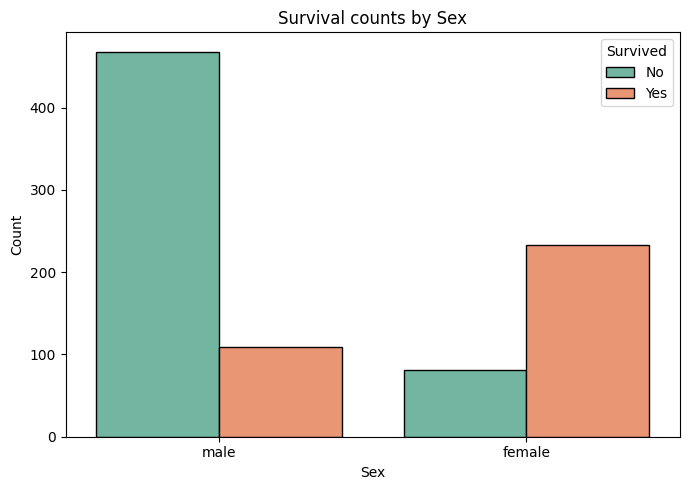

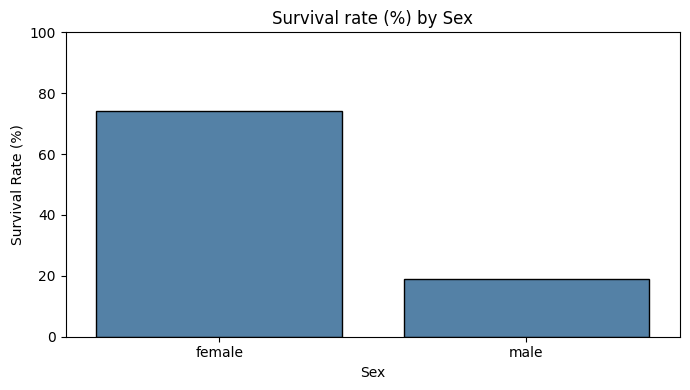

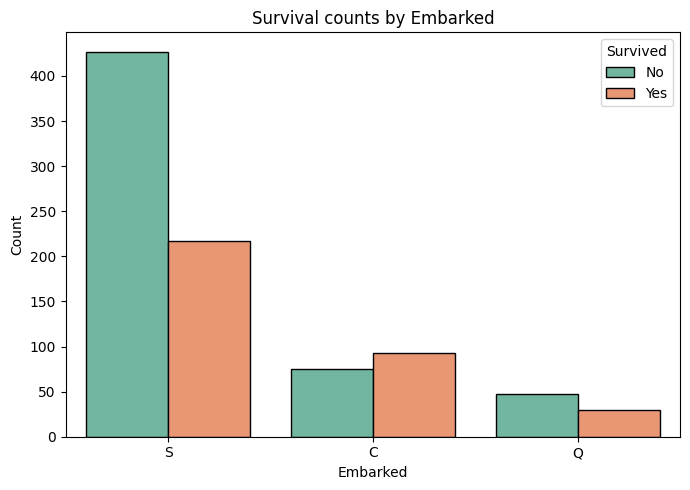

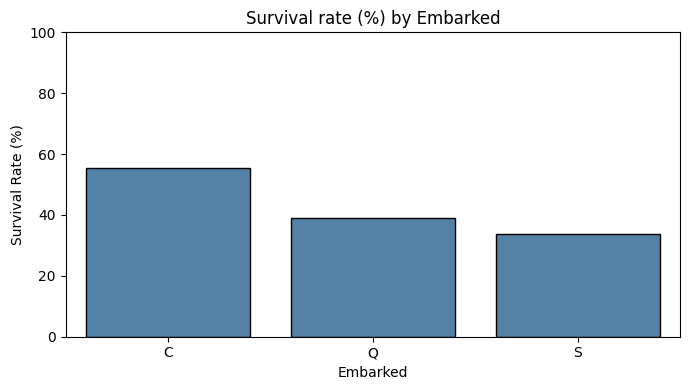

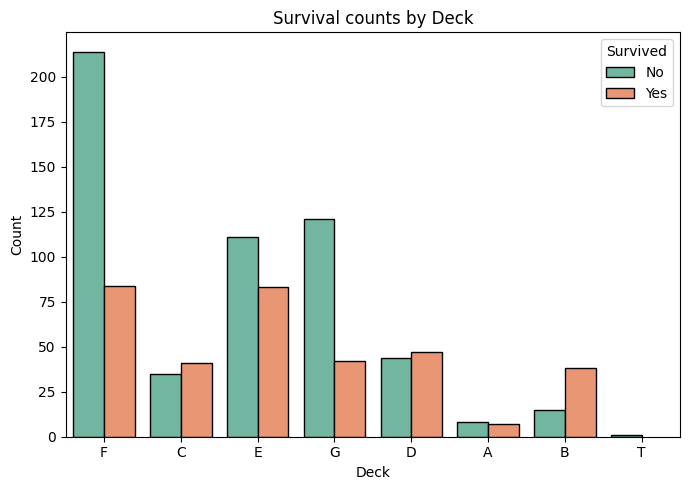

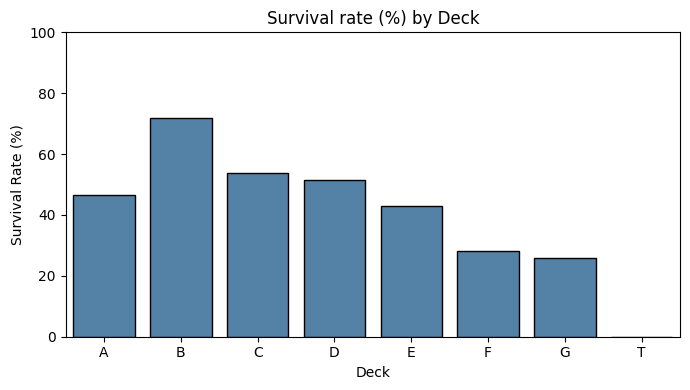

In [340]:
for col in ['Pclass', 'Sex', 'Embarked', 'Deck']:
    plot_survival_by_category(titanic_df, col)

In [341]:
def plot_survival_by_numeric(df, column_name):

    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')
    plt.title(f'{column_name} distribution by Survival')
    plt.xlabel('Survived')
    plt.ylabel(column_name)
    plt.xticks([0, 1], ['No', 'Yes'])
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-1970938091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')


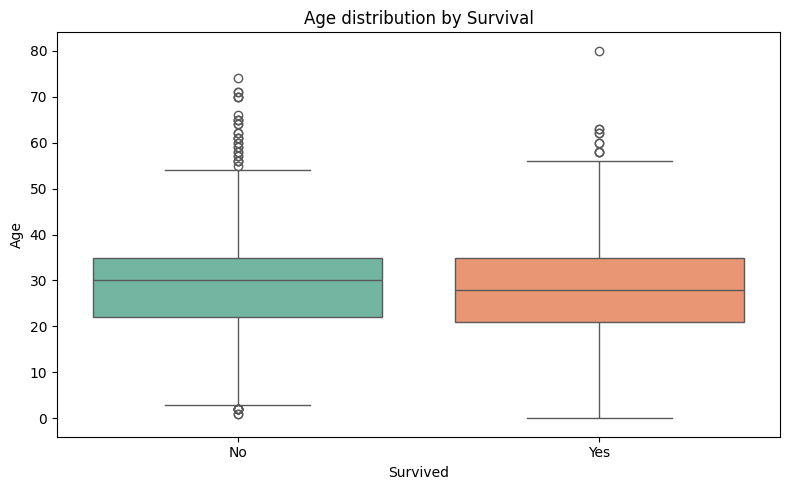

/tmp/ipython-input-1970938091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')


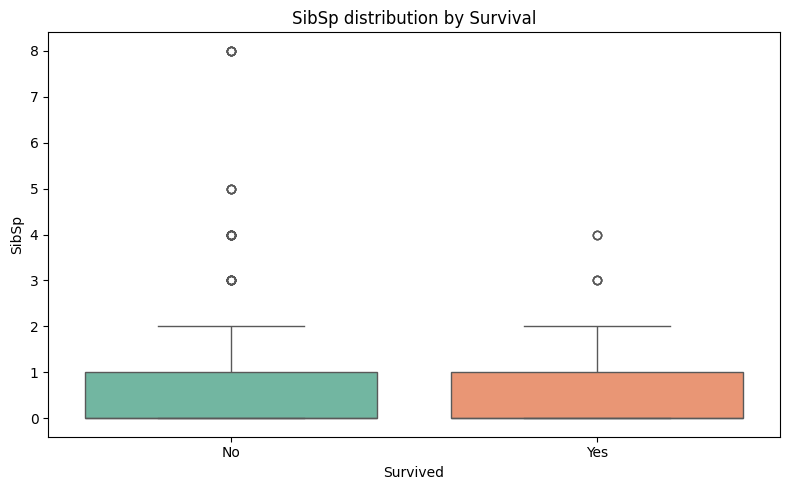

/tmp/ipython-input-1970938091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')


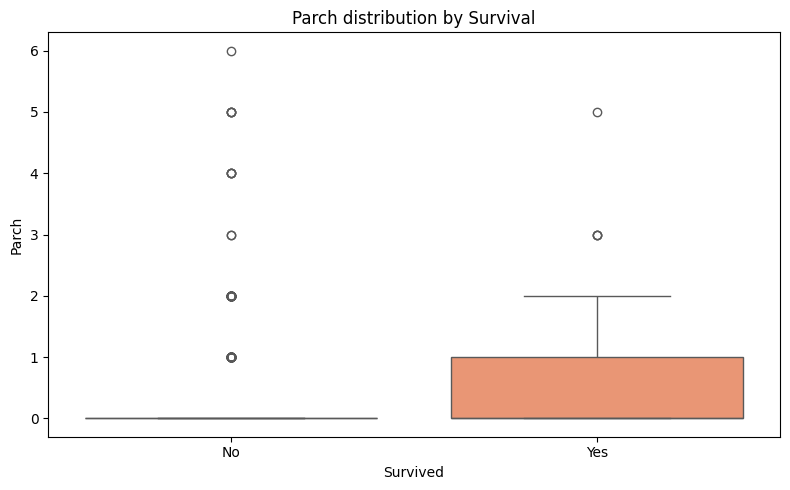

/tmp/ipython-input-1970938091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')


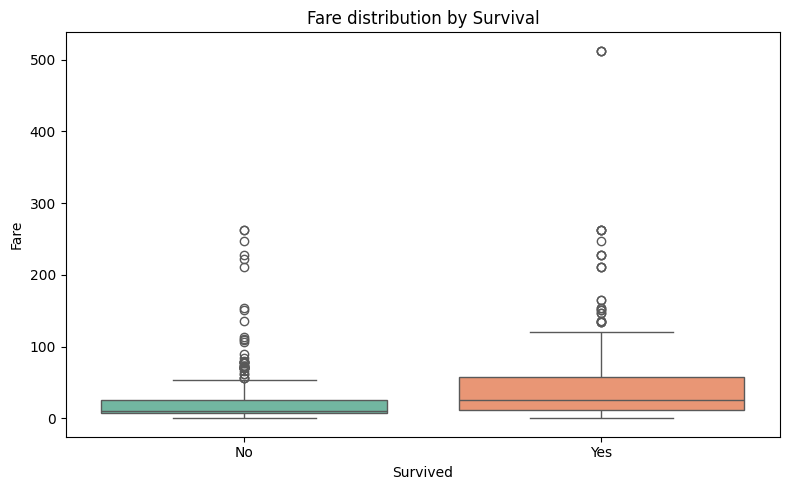

/tmp/ipython-input-1970938091.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Survived', y=column_name, palette='Set2')


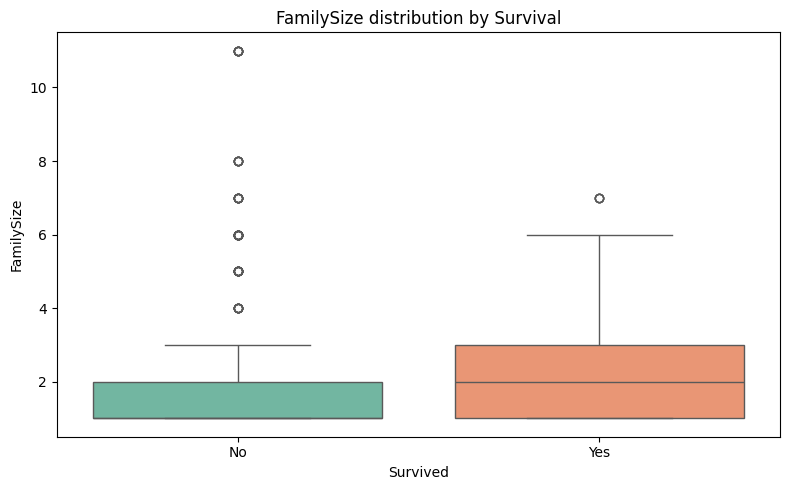

In [342]:
for col in ['Age', 'SibSp', 'Parch', 'Fare', 'FamilySize']:
    plot_survival_by_numeric(titanic_df, col)

**Stosujemy binary encoding dla kolumny** `Sex` **ze względu na tylko dwie wartości natomiast dla** `Embarked` **stosujemy one-hot encoding ze względu na brak hierachii między portami, dla** `Deck` **stosujemy Ordinal encoding ponieważ pokłady mają hierarchię, tworzymy macierz korelacji**


---




In [343]:
titanic_df['Sex']=titanic_df.Sex.map({"female":1,"male":0})

In [344]:
titanic_df['Embarked'].value_counts()

,count
Embarked,
S,644
C,168
Q,77


In [345]:
titanic_df = pd.get_dummies(titanic_df, columns=['Embarked'], drop_first=False)

In [346]:
mapping = {
    'A': 0,
    'B': 1,
    'C': 2,
    'D': 3,
    'E': 4,
    'F': 5,
    'G': 6,
    'T': 7,
}

titanic_df['Deck'] = titanic_df['Deck'].map(mapping)


In [347]:
def plot_correlation_matrix(df):
  corr = df.corr(numeric_only=True)
  plt.figure(figsize=(10, 8))
  sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
  plt.title('Correlation Matrix')
  plt.tight_layout()
  plt.show()

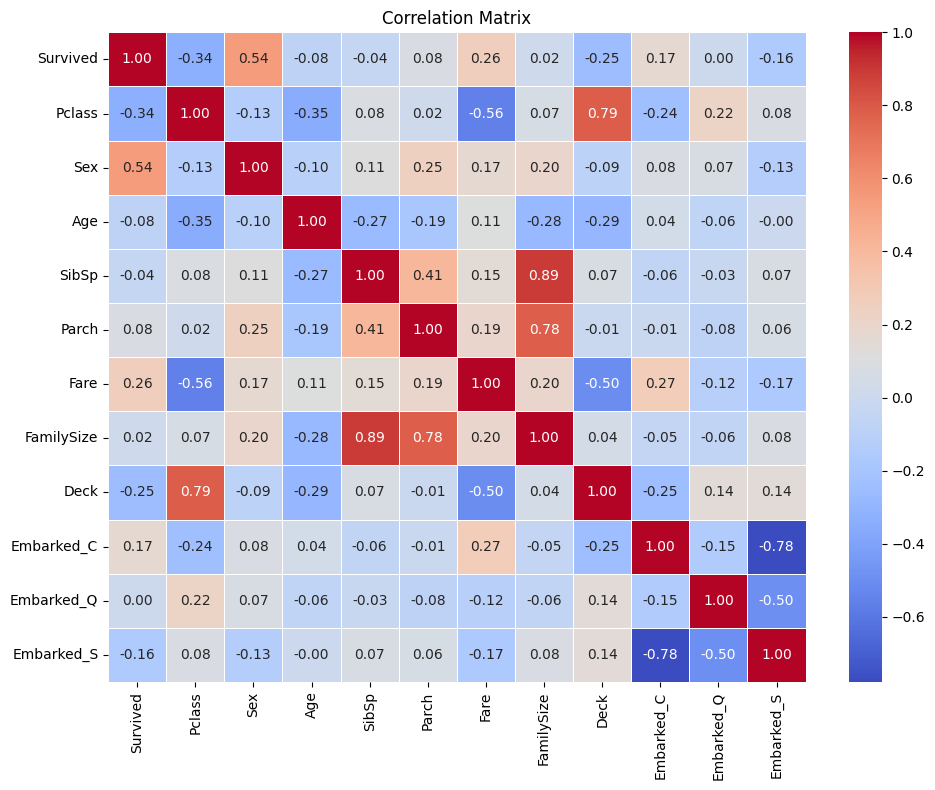

In [348]:
plot_correlation_matrix(titanic_df)

Na macierzy korelacji możemy zauważyć że Survived koreluje z płcią,opłatą za bilet oraz portem zaokrętowania Cherbourg.

Ku mojemu zdziwieniu klasa podróży i pokładu nie miała większego znaczenia w tym czy ktoś przeżył np. ktoś na wyższych pokładach mógł szybciej dotrzeć do szalup ratunkowych

# **2. Uczenie Maszynowe**

### Twoim celem będzie jest wytrenowanie modeli do klasyfikacji każdego pasażera Titanica jako ofiary (0) lub osoby, która przeżyła (1).

Poniżej znajdziesz pytania, które mogą być pomocne w zadaniu:

- Czego nauczyło Cię o badanym zbiorze danych poprzednie zadanie? Jak możesz wykorzystać wyciągnięte z niego wnioski w procesie tworzenia modelu?
- Jak przeprowadzenie standaryzacji danych może wpływać na zachowanie modelu?
- Co mój model robi i w jaki sposób?
- Jak nie przetrenować wybranego modelu?
- Jaki wynik klasyfikacji możemy uznać za *dobry*?


Wymagania:
- Wypisz obserwacje z pierwszego zadania, które pomogą Ci w tym. Co było przydatne, a co okazało się bezużyteczne?
- [Nie doprowadź](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) do ~~przecieku statku~~ wycieku danych (np. nie ucz modelu na danych testowych). Nauczone modele odpal na danych treningowych i testowych - opisz uzyskane wyniki.
- Stwórz baseline, czyli dla porównania sprawdź jak z zadaniem radzi sobie [Dummy Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.dummy.DummyClassifier.html) (jeśli Twój docelowy model radzi sobie gorzej - uciekaj)
- Przeprowadź badania na dwóch wybranych modelach uczenia maszynowego (np. spośród: drzew decyzyjnych, SVM, MLP, KNN, z gwiazdką [XGBoost](https://xgboost.readthedocs.io/en/stable))
- W badaniach użyj wybranych metryk. Wybór uzasadnij.
- Dla każdego modelu wybierz co najmniej dwa hiperparametry i przeprowadź badania zależności wyników metryk od wartości hiperparametrów. Zwizualizuj wszystko ładnie, zastanów się dlaczego tak mogło być i wyciągnij i wypisz wnioski.
- Podsumuj przeprowadzone badania, wypisz wnioski.

Niezmiennie, zadbaj o czytelność kodu i nazewnictwo zmiennych. Jeśli jakiś wycinek kodu się powtarza, to wyodrębnij go do funkcji. Postaraj się zamieszczać swoje wnioski w postaci komentarza `Markdown`.

Jeśli chcesz, możesz sprawdzić (przyjmując pewne założenia), jakie byłyby Twoje szanse na Titanicu.

Uwaga! Jeśli Titanic to dla Ciebie nic i baaaaardzo chcesz to możesz w ramach tego zadania zająć się [bardziej wymagającym](https://archive.ics.uci.edu/dataset/365/polish+companies+bankruptcy+data) zbiorem.

### Wybór modelu



---


  W poprzedniej części zadania skupialiśmy się głównie na eksploracyjnej analizie danych .

  Naszym zadaniem było doprowadzenie zbioru do tego by nie zawierał pustych wartości nan w tym celu po sprawdzeniu rozkładów danych uzupełniliśmy braki medianą dla wartości numerycznych a dla kategorycznych zastosowaliśmy losowe próbkowanie lub przy malutkich brakach uzupełnienie najczęstszą wartością.

  Zakodowaliśmy odpowiednio kolumny w zależności czy dane posiadały jakieś hierarchie między nimi,w celu późniejszego użycia w trenowaniu modelu przy okazji kodowania można było zauważyć że zbiór danych jest niezbalansowany a ta informacja przyda nam się do wybierania odpowiedniego modelu

---



Dokonujemy podzielenia zbioru danych na zbiór treningowy i testowy w celu zapobiegnięciu wycieku danych i późniejszym sprawdzeniu efektywności modelu jaką rzeczywistą efektywność on uzykuje.



---



In [349]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, classification_report
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.dummy import DummyClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import plot_tree

In [351]:
titanic_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,FamilySize,Deck,Embarked_C,Embarked_Q,Embarked_S
PassengerId,,,,,,,,,,,,
1,0,3,0,22,1,0,7.25,2,5,False,False,True
2,1,1,1,38,1,0,71.29,2,2,True,False,False
3,1,3,1,26,0,0,7.93,1,5,False,False,True
4,1,1,1,35,1,0,53.10,2,2,False,False,True
5,0,3,0,35,0,0,8.06,1,4,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...
887,0,2,0,27,0,0,13.00,1,5,False,False,True
888,1,1,1,19,0,0,30.00,1,1,False,False,True
889,0,3,1,21,1,2,23.45,4,6,False,False,True


In [352]:
X=titanic_df.drop(columns=['Survived'])
y=titanic_df['Survived']

In [353]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=13,shuffle=True, test_size=0.2)



---


Tworzymy baseline który posłuży nam jako kryterium porównawcze z późniejszymi modelami jeśli nieprzewyższą one baseline oznaczać będzie to że pojawił się gdzieś problem w danych.Wybieramy w tym celu strategię `most_frequent` która będzie zwracać najczęściej występującą wartość


---



In [354]:
model=DummyClassifier(strategy = 'most_frequent')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred, zero_division=0))
confusion_matrix(y_test, y_pred)

              precision    recall  f1-score   support

           0       0.61      1.00      0.76       110
           1       0.00      0.00      0.00        69

    accuracy                           0.61       179
   macro avg       0.31      0.50      0.38       179
weighted avg       0.38      0.61      0.47       179



array([[110,   0],
       [ 69,   0]])

In [350]:
def plot_cm(actual,predicted,Title,):
  sns.heatmap(confusion_matrix(actual,predicted),
            annot=True,
            fmt='g')
  plt.ylabel('Actual', fontsize=13)
  plt.title(f'Confusion Matrix - {Title}', fontsize=17, pad=20)
  plt.gca().xaxis.set_label_position('top')
  plt.xlabel('Prediction', fontsize=13)
  plt.gca().xaxis.tick_top()
  plt.gca().figure.subplots_adjust(bottom=0.2)
  plt.show()

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       110
           1       0.68      0.70      0.69        69

    accuracy                           0.75       179
   macro avg       0.74      0.74      0.74       179
weighted avg       0.76      0.75      0.75       179



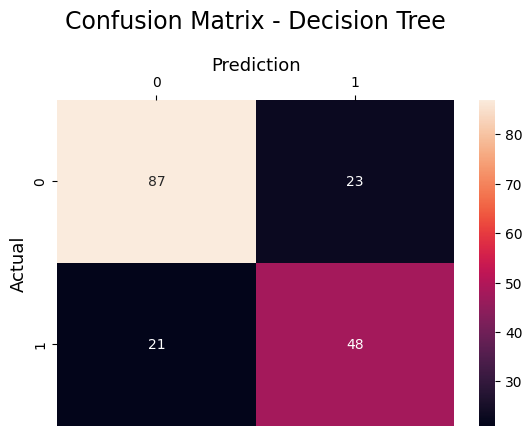

In [355]:
model = DecisionTreeClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred,'Decision Tree')



---


jak możemy dostrzec model spisuje się lepiej porównując do baselineu czyli możemy uznać że wszystko idzie jak narazie zgodnie z planem świadczyć może o tym wzrost precyzji i accuracy w f1 score


---



              precision    recall  f1-score   support

           0       0.86      0.85      0.86       110
           1       0.77      0.78      0.78        69

    accuracy                           0.83       179
   macro avg       0.82      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



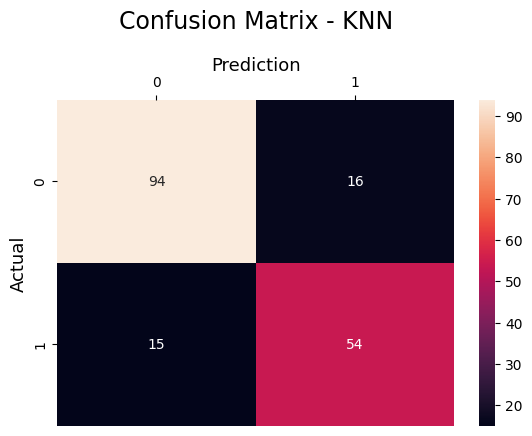

In [356]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier())
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred,'KNN')



---


Teraz musimy dobrać odpowiednie parametry do naszych modeli żeby ograniczyć prawdopodobieństwo wystąpienia overfittingu


---



In [357]:
cv=StratifiedKFold(shuffle=True,random_state=42)
depths=[2, 3, 4, 6, 8, 10]
min_splits=[2, 5, 10, 20, 50]

scores_matrix= np.zeros((len(depths), len(min_splits)))
for i ,d in enumerate(depths):
  for j, ms in enumerate(min_splits):
      model=DecisionTreeClassifier(max_depth=d, min_samples_split=ms, random_state=42)
      scores = cross_val_score(model, X_train, y_train, scoring='f1',cv=cv)
      scores_matrix[i, j] = scores.mean()

In [358]:
def f1_heatmap(scores_matrix,xtick,ytick,xlabel,ylabel,title):
  sns.heatmap(scores_matrix, annot=True, fmt=".3f", xticklabels=xtick, yticklabels=ytick, cmap="viridis")
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)
  plt.show()

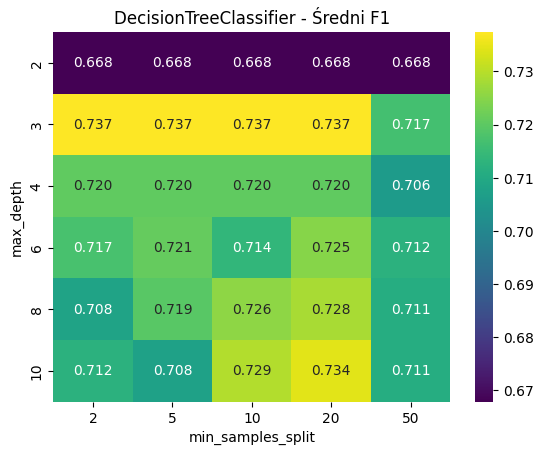

In [359]:
f1_heatmap(scores_matrix, min_splits,depths, "min_samples_split",
           "max_depth", "DecisionTreeClassifier - Średni F1")



---


decydujemy się na max_depth=6 i min_samples=10 gdyż jest to dobry balans między głębokością drzewa a ilością pobranych próbek

---


In [360]:
n_neighbors_range = [3,5,7,9,15,25]
weights_options = ["uniform", "distance"]

scores_knn = np.zeros((len(n_neighbors_range), len(weights_options)))
for i,k in enumerate(n_neighbors_range):
    for j,w in enumerate(weights_options):
        model = Pipeline([
            ("scaler", StandardScaler()),
            ("knn", KNeighborsClassifier(n_neighbors=k, weights=w))
        ])
        res = cross_val_score(model, X_train, y_train, scoring="f1", cv=cv)
        scores_knn[i,j] = res.mean()

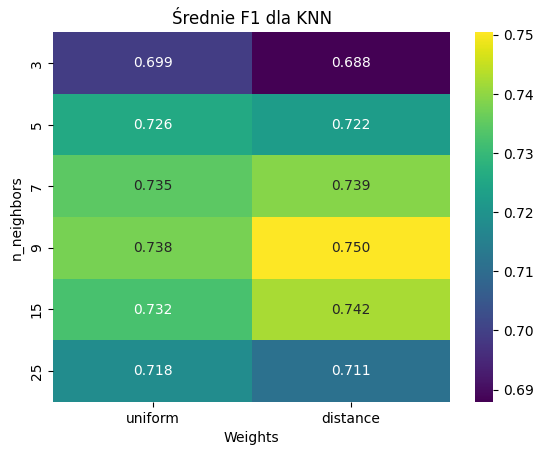

In [361]:
f1_heatmap(scores_knn, weights_options, n_neighbors_range,
           'Weights', 'n_neighbors', 'Średnie F1 dla KNN')



---


dla knn decydujemy się na `n_neighbours = 7 ` dla `Weights = 'distance'`


---



              precision    recall  f1-score   support

           0       0.84      0.92      0.88       110
           1       0.85      0.72      0.78        69

    accuracy                           0.84       179
   macro avg       0.84      0.82      0.83       179
weighted avg       0.84      0.84      0.84       179



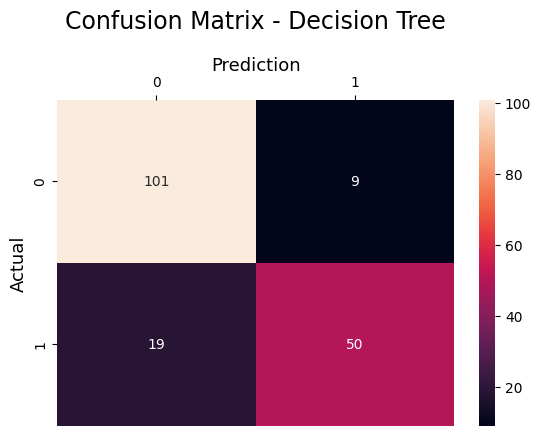

In [362]:
tree= DecisionTreeClassifier(max_depth=6, min_samples_split=10, random_state=42)
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred,'Decision Tree')

[Text(0.5, 0.9285714285714286, 'Sex <= 0.5\ngini = 0.473\nsamples = 712\nvalue = [439, 273]\nclass = Not Survived'),
 Text(0.2391304347826087, 0.7857142857142857, 'Age <= 13.0\ngini = 0.321\nsamples = 469\nvalue = [375, 94]\nclass = Not Survived'),
 Text(0.3695652173913043, 0.8571428571428572, 'True  '),
 Text(0.08695652173913043, 0.6428571428571429, 'SibSp <= 2.5\ngini = 0.486\nsamples = 36\nvalue = [15, 21]\nclass = Survived'),
 Text(0.043478260869565216, 0.5, 'FamilySize <= 1.5\ngini = 0.091\nsamples = 21\nvalue = [1, 20]\nclass = Survived'),
 Text(0.021739130434782608, 0.35714285714285715, 'gini = 0.0\nsamples = 1\nvalue = [1, 0]\nclass = Not Survived'),
 Text(0.06521739130434782, 0.35714285714285715, 'gini = 0.0\nsamples = 20\nvalue = [0, 20]\nclass = Survived'),
 Text(0.13043478260869565, 0.5, 'FamilySize <= 6.5\ngini = 0.124\nsamples = 15\nvalue = [14, 1]\nclass = Not Survived'),
 Text(0.10869565217391304, 0.35714285714285715, 'gini = 0.0\nsamples = 9\nvalue = [9, 0]\nclass = No

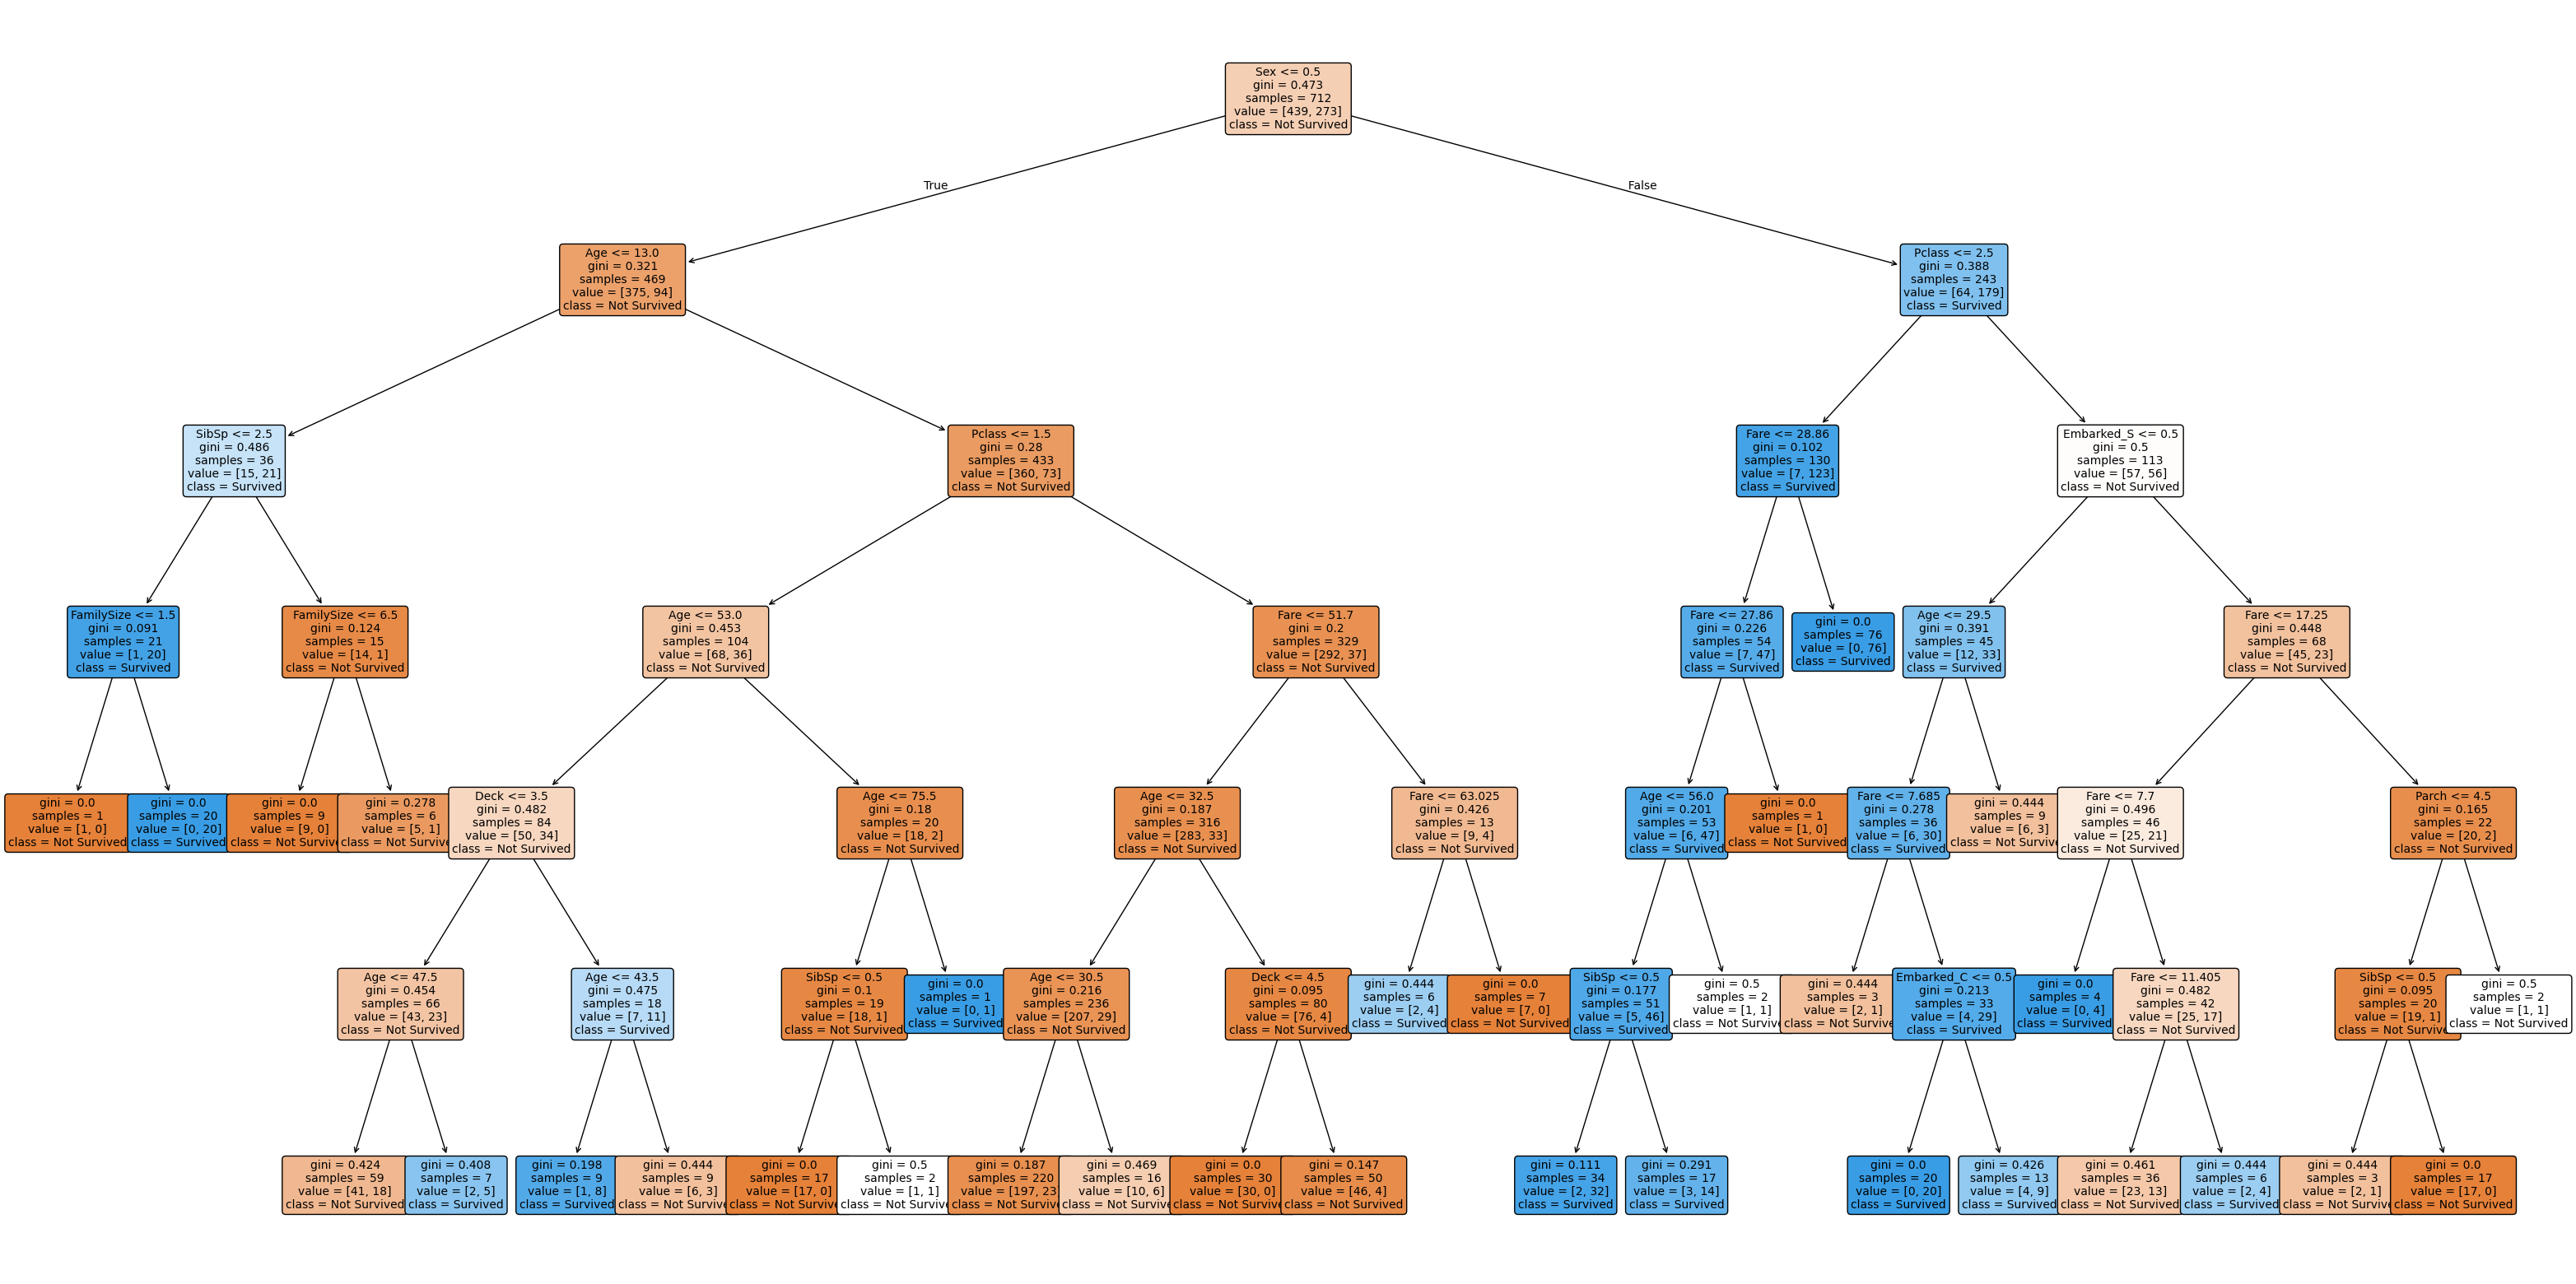

In [368]:
plt.figure(figsize=(40,20))
plot_tree(tree, feature_names=X.columns,
          class_names=["Not Survived","Survived"],
          filled=True, rounded=True, fontsize=10)

Jak widać po zastosowaniu `max_depth = 6`, `min_samples_split = 10`
otrzymaliśmy najwyższą dokładność i kompromis pomiędzy precision, recall
która wygląda tak `Accuracy 0.84`
`Precision 0.85` rzadko dostaje fałszywe alarmy
`Recall 0.72`część pozytywów umyka
`F1 0.78`
gdzie w porówaniu do modelu gdzie nie zastosowaliśmy parametrów
`Accuracy 0.75`
`Precision 0.68`
`Recall 0.70`
`F1 0.69`

              precision    recall  f1-score   support

           0       0.86      0.82      0.84       110
           1       0.73      0.78      0.76        69

    accuracy                           0.80       179
   macro avg       0.79      0.80      0.80       179
weighted avg       0.81      0.80      0.81       179



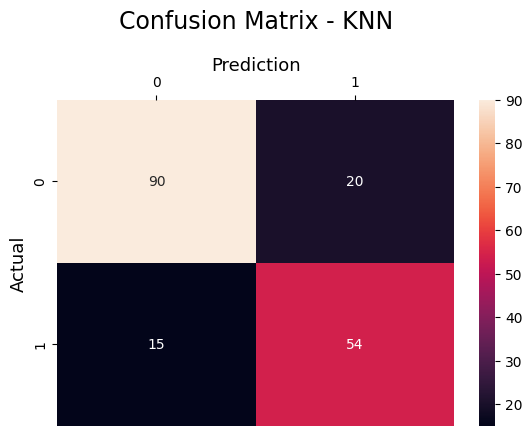

In [364]:
model = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance'))
])
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))
plot_cm(y_test, y_pred,'KNN')

In [365]:
feat1, feat2 = X_train.columns[:2]
X_train_2d = X_train[[feat1, feat2]]
X_test_2d = X_test[[feat1, feat2]]

In [366]:
model_2d = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=7, weights='distance'))
])
model_2d.fit(X_train_2d, y_train)
x_min, x_max = X_train_2d[feat1].min() - 1, X_train_2d[feat1].max() + 1
y_min, y_max = X_train_2d[feat2].min() - 1, X_train_2d[feat2].max() + 1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 300),
                     np.linspace(y_min, y_max, 300))

Z = model_2d.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

/usr/local/lib/python3.11/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


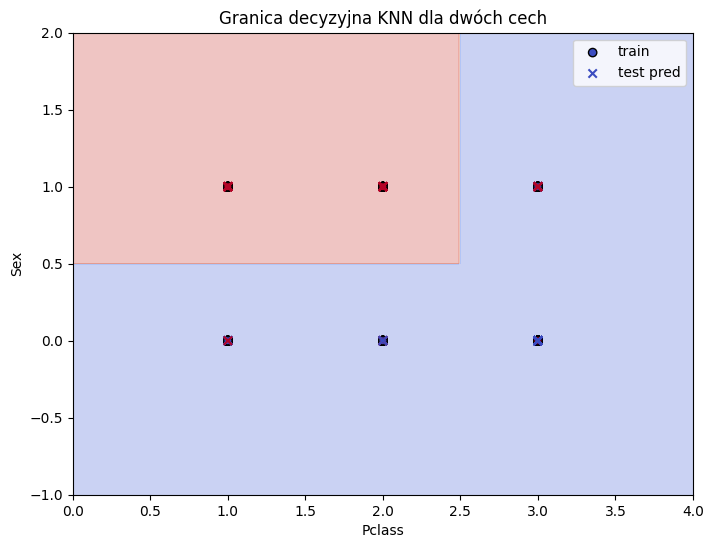

In [367]:
plt.figure(figsize=(8,6))
plt.contourf(xx, yy, Z, alpha=0.3, cmap=plt.cm.coolwarm)
plt.scatter(X_train_2d[feat1], X_train_2d[feat2], c=y_train,
            edgecolor='k', cmap=plt.cm.coolwarm, label='train')
plt.scatter(X_test_2d[feat1], X_test_2d[feat2], c=y_pred,
            marker='x', cmap=plt.cm.coolwarm, label='test pred')
plt.xlabel(feat1)
plt.ylabel(feat2)
plt.legend()
plt.title("KNN decision boundary for two features")
plt.show()

widzimy pogorszenie się modelu po zastosowaniu parametru  (prawdopodobnie wina złej dobranej wartości) mimo tego możemy zobaczyć że drzewo charakteryzowało się w przypadku tego zbioru danych większą precyzją